In [5]:
import sys
import pickle
import numpy as np
from numpy import array, ndarray
from pandas import read_csv, DataFrame, Series, concat
from matplotlib.pyplot import figure, savefig, show, subplots
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from scipy.stats import norm, expon, lognorm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

sys.path.insert(1, '../../../../utils')
from dslabs_functions import get_variable_types, \
  CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart, plot_multiline_chart, plot_evaluation_results, \
  plot_horizontal_bar_chart, HEIGHT, plot_line_chart, dummify, run_NB, run_KNN, plot_multibar_chart, \
  encode_cyclic_variables, plot_confusion_matrix, NR_STDEV, determine_outlier_thresholds_for_var
from studies import naive_Bayes_study, knn_study, evaluate_approach, evaluate_and_plot 


### **Scaling** ###

In [9]:
lab_folder = "lab3_preparation/scaling"
file_tag = "traffic"
# task = "scaling"
target_name = "crash_type"

# filename = "../../data/prepared/traffic_outliers_drop_outliers.csv"
# filename = "../../data/prepared/traffic_outliers_replacing_outliers.csv"
filename = "../../data/prepared/traffic_outliers_truncate_outliers.csv"

input_df = read_csv(filename, na_values="")

In [10]:
filename_raw = "../../data/raw/traffic_accidents.csv"
df_raw: DataFrame = read_csv(filename_raw, na_values="")
variable_types: dict[str, list] = get_variable_types(df_raw)

In [11]:
numeric_vars = variable_types['numeric']
df_raw[numeric_vars].head()

,num_units,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,2,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,2,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,3,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,2,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,2,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


### Approach 1 - Standard Scaler

In [ ]:
approach = "1"

data_sca1 = input_df.copy()
target: Series = data_sca1.pop(target_name)

numeric_df = data_sca1[numeric_vars].copy()
transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(
    numeric_df
)
numeric_df_scaled = DataFrame(transf.transform(numeric_df), index=data_sca1.index)
data_sca1[numeric_vars] = numeric_df_scaled
data_sca1[target_name] = target
evaluate_and_plot(data_sca1, lab_folder, file_tag, approach, target_name)

### Approach 2 - MinMax Scaler

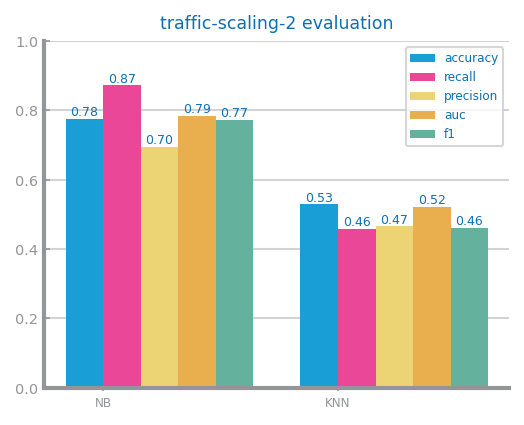

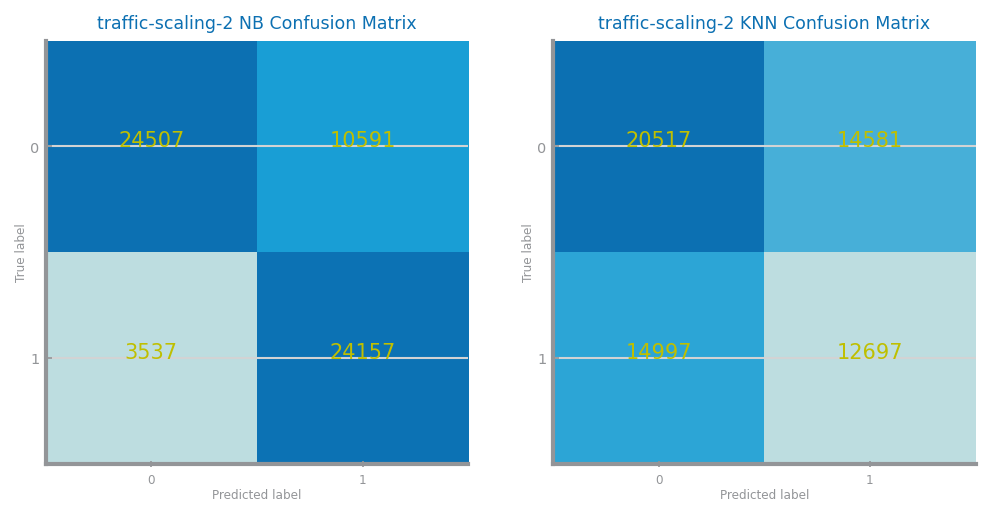

In [ ]:
from sklearn.preprocessing import MinMaxScaler

approach = "2"

data_sca2 = input_df.copy()
target: Series = data_sca2.pop(target_name)

numeric_df = data_sca2[numeric_vars].copy()
transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(numeric_df)
numeric_df_scaled = DataFrame(transf.transform(numeric_df), index=data_sca2.index)
data_sca2[numeric_vars] = numeric_df_scaled
data_sca2[target_name] = target
evaluate_and_plot(data_sca2, lab_folder, file_tag, approach, target_name)

### **Balancing** ###

In [ ]:
task = "balancing"
input_df = data_sca2.copy()

### Approach 1 - Undersampling

Class distribution before undersampling:
crash_type
0    117376
1     91930
Name: count, dtype: int64
Ratio: 1.28:1

Class distribution after undersampling:
crash_type
1    91930
0    91930
Name: count, dtype: int64
Dataset size: 209306 → 183860 (87.8%)


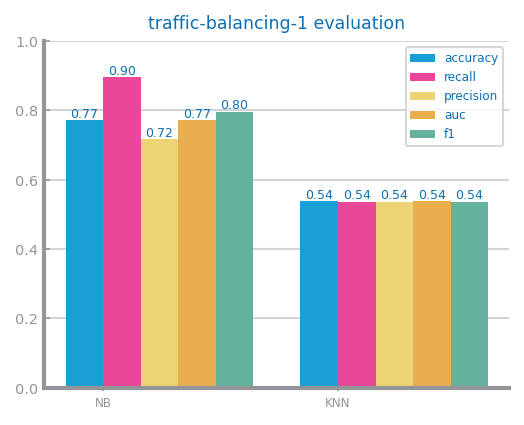

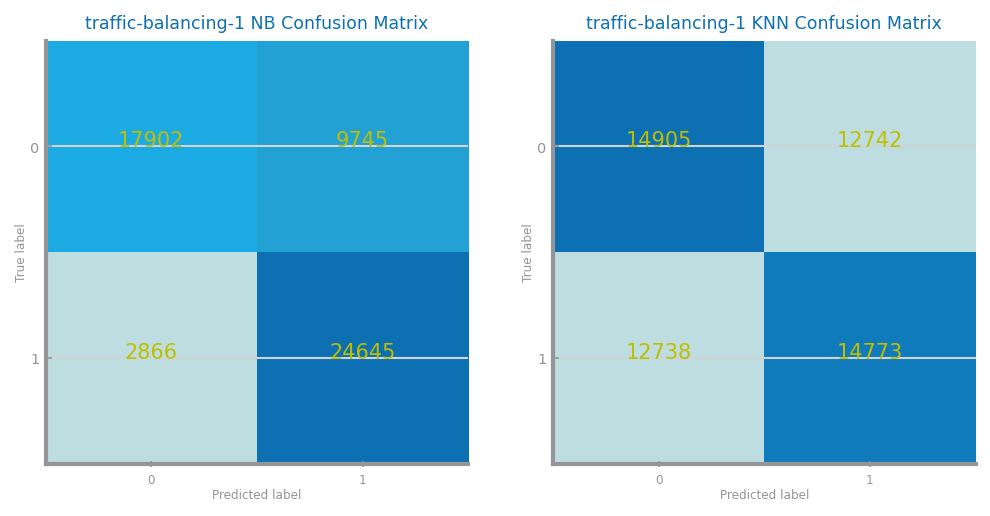

In [ ]:
from pandas import value_counts

approach = "1"

# Check class distribution before balancing
print("Class distribution before undersampling:")
print(input_df[target_name].value_counts())
print(f"Ratio: {input_df[target_name].value_counts()[0] / input_df[target_name].value_counts()[1]:.2f}:1")

# Separate majority and minority classes
df_majority = input_df[input_df[target_name] == 0]
df_minority = input_df[input_df[target_name] == 1]

# Undersample majority class to match minority class size
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with undersampled majority class
data_bal1 = concat([df_majority_undersampled, df_minority])

# Shuffle the dataset
data_bal1 = data_bal1.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nClass distribution after undersampling:")
print(data_bal1[target_name].value_counts())
print(f"Dataset size: {len(input_df)} → {len(data_bal1)} ({100*len(data_bal1)/len(input_df):.1f}%)")

# Evaluate
evaluate_and_plot(data_bal1, file_tag, task, approach, target_name)

### Approach 2 - SMOTE (Synthetic Minority Over-sampling Technique)

Class distribution before SMOTE:
crash_type
0    117376
1     91930
Name: count, dtype: int64

Class distribution after SMOTE:
crash_type
0    117376
1    117376
Name: count, dtype: int64
Dataset size: 209306 → 234752 (112.2%)

Class distribution after SMOTE:
crash_type
0    117376
1    117376
Name: count, dtype: int64
Dataset size: 209306 → 234752 (112.2%)


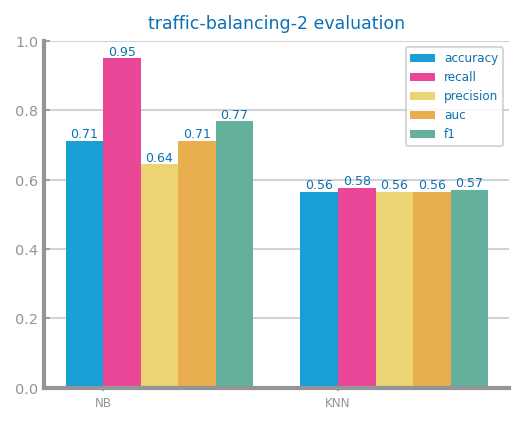

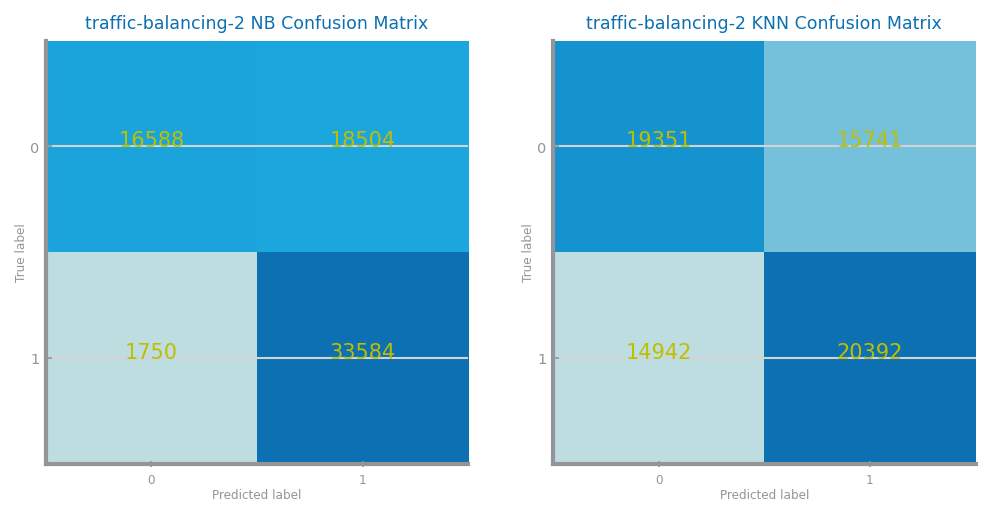

In [ ]:
from imblearn.over_sampling import SMOTE

approach = "2"

# Check class distribution before balancing
print("Class distribution before SMOTE:")
print(input_df[target_name].value_counts())

# Separate features and target
X = input_df.drop(columns=[target_name])
y = input_df[target_name]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine back into DataFrame
data_bal2 = DataFrame(X_resampled, columns=X.columns)
data_bal2[target_name] = y_resampled

print(f"\nClass distribution after SMOTE:")
print(data_bal2[target_name].value_counts())
print(f"Dataset size: {len(input_df)} → {len(data_bal2)} ({100*len(data_bal2)/len(input_df):.1f}%)")

# Evaluate
evaluate_and_plot(data_bal2, file_tag, task, approach, target_name)

### **Feature Selection** ###